In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import netket as nk
from netket.utils import HashableArray
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import pickle
from netket.callbacks import InvalidLossStopping
# import the ViT model
import sys
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/models')
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/Logger_Pickle')

from json_log import PickledJsonLog
# from ViT_2d_Vers2_Checkpoint import *
from vmc_2spins_sampler import *
from Afm_Model_functions import *
# from ViTmodel_2d_Vers2 import * 
import ViT_2d_Vers3_XavierUniform as vitX

from convergence_stopping import LateConvergenceStopping
# import the sampler choosing between minSR and regular SR
from optax.schedules import cosine_decay_schedule, linear_schedule



We start by 



good params mean if we sample some spin configurations we want to get only states with low magnetizatioin!

finding good samples for 8x8 d24 nl1 and patch_xy = 12

In [3]:
L = 10

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)


pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,8,9,10,11]
}

Ha16, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = None, make_rotation=False, exchange_XY=False)

XX = Exchange_OP(hi2d, TriGraph).to_jax_operator()

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
# sa_2flip = nk.sampler.MetropolisSampler(hilbert=hi2d, rule=TwoLocalRule(), n_chains=32, sweep_size=3*hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)


rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
rules3070 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.3, 0.7])
rules7030 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.7, 0.3])

sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=32, sweep_size=3*hi2d.size)
sa_HaEx3070 = nk.sampler.MetropolisSampler(hi2d, rules3070, n_chains=32, sweep_size=3*hi2d.size)
sa_HaEx7030 = nk.sampler.MetropolisSampler(hi2d, rules7030, n_chains=32, sweep_size=3*hi2d.size)


In [4]:
pVit = {
    'd': 24,
    'h': 6,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 1,
    'Cy': 2,
    'patch_arr': HashableArray(np.arange(0, L**2).reshape((-1,2))),
}

m_Vit = vitX.ViT_2d(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'])



In [5]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx5050, model = m_Vit, n_samples=2**12, chunk_size=2**12, n_discard_per_chain=16)

/scratch/samiz/GPU_ViT_Calcs/venv/lib/python3.11/site-packages/netket/hilbert/random/homogeneous.py:123: UnoptimisedCustomConstraintRandomStateMethodWarning: 
Defaulting to a slow, possibly infinitely-looping method to generate random state of
the current Hilbert space with a custom constraint. Consider implementing a
custom `random_state` method for your constraint if this method takes a long time to
generate a random state.

You can silence this warning by setting the environment variable
``NETKET_RANDOM_STATE_FALLBACK_WARNING=0``
or by setting ``nk.config.netket_random_state_fallback_warning = False``
in your code.

To generate a custom random_state dispatched method, you should use multiple dispatch
following the following syntax:

>>> import netket as nk
>>> from netket.utils import dispatch
>>>
>>> @dispatch.dispatch
>>> def random_state(hilb: netket.hilbert.spin.Spin,
                    constraint: vmc_2spins_sampler.Mtot_Parity_Constraint,
                    key,
            

In [70]:
start_configs = hi2d.random_state(jax.random.PRNGKey(0), 2**10)
p_init = m_Vit.init(jax.random.PRNGKey(30), start_configs)
vs_vit.variables = p_init

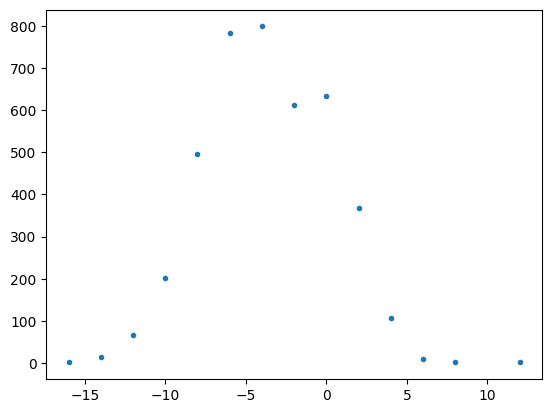

In [71]:
x,y = jnp.unique(jnp.sum(vs_vit.sample().reshape(-1, L**2), axis=-1)/2, return_counts=True)

plt.plot(x,y, '.')

In [ ]:
with open('init_params5050.pickle', 'wb') as f:
    pickle.dump(p_init, f)

In [17]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx7030, model = m_Vit, n_samples=2**12, chunk_size=2**12, n_discard_per_chain=16)

In [66]:
start_configs = hi2d.random_state(jax.random.PRNGKey(0), 2**10)
p_init = m_Vit.init(jax.random.PRNGKey(6), start_configs)   # 0 works ok-ish
vs_vit.variables = p_init

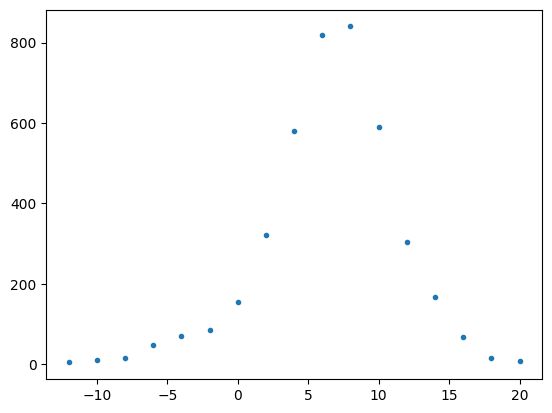

In [67]:
x,y = jnp.unique(jnp.sum(vs_vit.sample().reshape(-1, L**2), axis=-1)/2, return_counts=True)

plt.plot(x,y, '.')

In [ ]:
with open('init_params7030.pickle', 'wb') as f:
    pickle.dump(p_init, f)

In [87]:
with open('good_init_params5050.pickle', 'rb') as f:
    p_init_test = pickle.load(f)

In [88]:
vs_vit.variables = p_init_test

In [ ]:
start_configs = hi2d.random_state(jax.random.PRNGKey(0), 2**10)
p_init = m_Vit.init(jax.random.PRNGKey(0), start_configs)   # 0 works ok-ish

In [ ]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx3070, model = m_Vit, n_samples=2**12, chunk_size=2**12, n_discard_per_chain=16)
vs_vit.variables = p_init

In [ ]:
vs_vit.variables = p_init

x,y = jnp.unique(jnp.sum(vs_vit.samples.reshape(-1, L**2), axis=-1)/2, return_counts=True)

plt.plot(x,y, '.')

In [ ]:
with open('init_params3070.pickle', 'wb') as f:
    pickle.dump(p_init, f)